<a href="https://colab.research.google.com/github/ArmandDS/bert_for_long_text/blob/master/final_bert_long_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
np.random.seed(1337)
from keras import Sequential
from keras.utils import Sequence
from keras.layers import LSTM, Dense, Masking
import numpy as np
import keras
from keras.utils import np_utils
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Embedding, Dense, Input, concatenate, Layer, Lambda, Dropout, Activation
import datetime
from datetime import datetime
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, TensorBoard
import tensorflow as tf
import tensorflow_hub as hub

from cleantext import clean
import pickle
import string

Using TensorFlow backend.


# Loading The Data

In [2]:
train_raw = pd.read_pickle('Train_data')
test_raw = pd.read_pickle('Test_data')
train_raw.head()

,host,text,label_text,label_num
0,9032,#polepharma » flux polepharma » flux des co...,health/medical,3
1,5346,301 moved permanen...,entertainment,2
2,18778,(button) fermer en poursuivant votre navi...,entertainment,2
3,11939,#hal (button) toggle navigation ccsd ...,education/research,1
4,17502,user-agent: * disallow: disallow: /publishe...,tech/science,7


In [3]:
print(train_raw.shape)
print(test_raw.shape)

(2125, 4)
(560, 2)


# Preprocessing Data

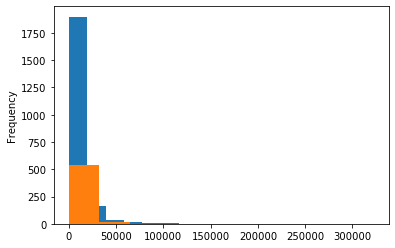

In [4]:
train_raw.text.apply(lambda x: len(x.split())).plot(kind='hist')
test_raw.text.apply(lambda x: len(x.split())).plot(kind='hist')

In [5]:
train_raw['len_txt'] = train_raw.text.apply(lambda x: len(x.split()))
test_raw['len_txt'] = train_raw.text.apply(lambda x: len(x.split()))
train_raw.describe()

,label_num,len_txt
count,2125.000000,2125.000000
mean,2.485176,7800.792941
std,2.418423,14526.236363
min,0.000000,0.000000
25%,0.000000,1053.000000
50%,2.000000,3043.000000
75%,5.000000,8487.000000
max,7.000000,194304.000000


In [6]:
print(train_raw.shape)
print(test_raw.shape)

(2125, 5)
(560, 3)


Select only the row with number of words greater than 250: maybe ?

In [7]:
train_raw = train_raw[['host','text', 'label_text']]
train_raw.reset_index(inplace=True, drop=True)
train_raw.head()

,host,text,label_text
0,9032,#polepharma » flux polepharma » flux des co...,health/medical
1,5346,301 moved permanen...,entertainment
2,18778,(button) fermer en poursuivant votre navi...,entertainment
3,11939,#hal (button) toggle navigation ccsd ...,education/research
4,17502,user-agent: * disallow: disallow: /publishe...,tech/science


Group similar products

In [8]:
for l in np.unique(train_raw['label_text']):
  print(l)

business/finance
education/research
entertainment
health/medical
news/press
politics/government/law
sports
tech/science


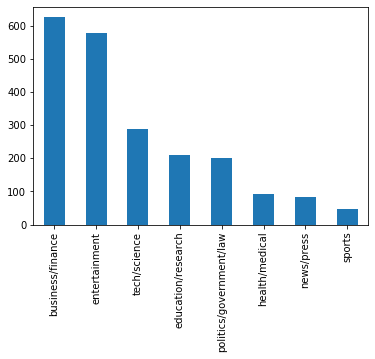

In [9]:
train_raw['label_text'].value_counts().sort_values(ascending=False).plot(kind='bar')

In [10]:
from sklearn.preprocessing import LabelEncoder

LE = LabelEncoder()
train_raw['label'] = LE.fit_transform(train_raw['label_text'])
train_raw.head()

,host,text,label_text,label
0,9032,#polepharma » flux polepharma » flux des co...,health/medical,3
1,5346,301 moved permanen...,entertainment,2
2,18778,(button) fermer en poursuivant votre navi...,entertainment,2
3,11939,#hal (button) toggle navigation ccsd ...,education/research,1
4,17502,user-agent: * disallow: disallow: /publishe...,tech/science,7


In [11]:
len(np.unique(train_raw['label']))

8

In [12]:
train = train_raw.copy()
test = test_raw.copy()

In [13]:
from sklearn.model_selection import train_test_split
train, val = train_test_split(train, test_size=0.1, random_state=35)
train.head()

,host,text,label_text,label
1847,7587,aller au contenu principal (button) ouvri...,business/finance,0
357,16150,fort young hotel * overview * rooms...,entertainment,2
1827,9841,301moved permanently the document has been p...,business/finance,0
1879,6441,#alternate alternate alternate alternate a...,business/finance,0
522,8533,#rss * [750g_influenceurs.png] * __...,entertainment,2


In [44]:
train['text'][0]

'   #polepharma » flux polepharma » flux des commentaires alternate   alternate   polepharma   polepharma \ufeff recherche_________ submit   (button) toggle navigation   polepharma     * polepharma          + qui sommes-nous ?          + organigramme          + les chiffres clés          + un réseau     * territoires          + région centre-val de loire          + région normandie          + conseil départemental d’eure&loir          + chartres metropole          + metropole de rouen          + agglo du pays de dreux          + agglo evreux portes de normandie          + agglo seine&eure          + agglo de tours plus     * performance industrielle          + excellence opérationnelle          + maintenance          + packaging          + supply chain          + usine du futur     * talents     * relations publiques     * innovation          + biomédicaments          + fédérer          + collaborer          + promouvoir   adhérer à polepharma   espace adhérent   rechercher un adhérent

In [14]:
train.reset_index(drop=True, inplace=True)
train.head(2)

,host,text,label_text,label
0,7587,aller au contenu principal (button) ouvri...,business/finance,0
1,16150,fort young hotel * overview * rooms...,entertainment,2


In [15]:
val.reset_index(drop=True, inplace=True)
val.head(2)

,host,text,label_text,label
0,13528,#extranet icp rss aller au contenu princi...,politics/government/law,5
1,3604,iframe: https://www.googletagmanager.com/ns...,entertainment,2


In [16]:
val.shape, train.shape

((213, 4), (1912, 4))

# Setting The Output Directory for BERT

In [17]:
# Set the output directory for saving model file
OUTPUT_DIR = '/bert_news_category'

#@markdown Whether or not to clear/delete the directory and create a new one
DO_DELETE = True #@param {type:"boolean"}

if DO_DELETE:
  try:
    tf.io.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.io.gfile.makedirs(OUTPUT_DIR)
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))

***** Model output directory: /bert_news_category *****


In [18]:
print("Training Set Shape :", train.shape)
print("Validation Set Shape :", val.shape)
# print("Test Set Shape :", test.shape)

Training Set Shape : (1912, 4)
Validation Set Shape : (213, 4)


In [19]:
DATA_COLUMN = 'text'
LABEL_COLUMN = 'label_text'
# The list containing all the classes (train['SECTION'].unique())
label_list = [x for x in np.unique(train.label_text)]
label_list

['business/finance',
 'education/research',
 'entertainment',
 'health/medical',
 'news/press',
 'politics/government/law',
 'sports',
 'tech/science']

# Splitting the Data into smaller chunks

In [20]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total

In [21]:
train['text_split'] = train[DATA_COLUMN].apply(get_split)
train.head()

,host,text,label_text,label,text_split
0,7587,aller au contenu principal (button) ouvri...,business/finance,0,[aller au contenu principal (button) ouvrir le...
1,16150,fort young hotel * overview * rooms...,entertainment,2,[fort young hotel * overview * rooms * dining ...
2,9841,301moved permanently the document has been p...,business/finance,0,[301moved permanently the document has been pe...
3,6441,#alternate alternate alternate alternate a...,business/finance,0,[#alternate alternate alternate alternate alte...
4,8533,#rss * [750g_influenceurs.png] * __...,entertainment,2,[#rss * [750g_influenceurs.png] * ____________...


In [22]:
val['text_split'] = val[DATA_COLUMN].apply(get_split)
val.head(2)

,host,text,label_text,label,text_split
0,13528,#extranet icp rss aller au contenu princi...,politics/government/law,5,[#extranet icp rss aller au contenu principalh...
1,3604,iframe: https://www.googletagmanager.com/ns...,entertainment,2,[iframe: https://www.googletagmanager.com/ns.h...


In [23]:
test['text_split'] = test[DATA_COLUMN].apply(get_split)
train_raw['text_split'] = train_raw[DATA_COLUMN].apply(get_split)



In [ ]:
test.to_pickle("split_test")
train_raw.to_pickle("split_train")

In [24]:
train_l = []
label_l = []
index_l =[]
for idx,row in train.iterrows():
  for l in row['text_split']:
    train_l.append(l)
    label_l.append(row['label'])
    index_l.append(idx)
len(train_l), len(label_l), len(index_l)

(96119, 96119, 96119)

In [25]:
val_l = []
val_label_l = []
val_index_l = []
for idx,row in val.iterrows():
  for l in row['text_split']:
    val_l.append(l)
    val_label_l.append(row['label'])
    val_index_l.append(idx)
len(val_l), len(val_label_l), len(val_index_l)

(13555, 13555, 13555)

In [26]:
test_l = []
test_index_l = []
for idx,row in test.iterrows():
  for l in row['text_split']:
    test_l.append(l)
    test_index_l.append(idx)
len(test_l), len(test_index_l)

(28229, 28229)

In [27]:
train_raw_l = []
label_raw_l = []
index_raw_l =[]
for idx,row in train_raw.iterrows():
  for l in row['text_split']:
    train_raw_l.append(l)
    label_raw_l.append(row['label'])
    index_raw_l.append(idx)
len(train_raw_l), len(label_raw_l), len(index_raw_l)

(109674, 109674, 109674)

The final dataset for training:

In [28]:
train_df = pd.DataFrame({DATA_COLUMN:train_l, LABEL_COLUMN:label_l})
train_df.head()

,text,label_text
0,aller au contenu principal (button) ouvrir le ...,0
1,1. accueilinitiatives associations : comment b...,0
2,en savoir plus sur salon de l'étudiant paris 1...,0
3,lien s'ouvre dans une nouvelle fenêtre) * en v...,0
4,la page d'accueil du site publicnavigation sec...,0


In [29]:
val_df = pd.DataFrame({DATA_COLUMN:val_l, LABEL_COLUMN:val_label_l})
val_df.head()

,text,label_text
0,#extranet icp rss aller au contenu principalho...,5
1,iframe: https://www.googletagmanager.com/ns.ht...,2
2,+ bas-rhin + haut-rhin + chuchotements + courr...,2
3,gilets jaunes + affaire reiser + attentat du 1...,2
4,"été dénoncé par un proche arrêté en écosse, du...",2


In [30]:
test_df = pd.DataFrame({DATA_COLUMN:test_l})
test_df.head()

,text
0,iframe: //www.googletagmanager.com/ns.html?id=...
1,self. scroll down mind expansive thinking deve...
2,service close faith & service no matter what y...
3,and conservation. quad canisius jumps four spo...
4,iframe: https://www.googletagmanager.com/ns.ht...


In [33]:
train_raw_df = pd.DataFrame({DATA_COLUMN:train_raw_l, LABEL_COLUMN:label_raw_l})
train_raw_df.head()

,text,label_text
0,#polepharma » flux polepharma » flux des comme...,3
1,territoires + région centre-val de loire + rég...,3
2,octobre 2019 à biocitech (romainville-grand pa...,3
3,"de thierry ziegler, head of manufacturing de c...",3
4,européens... > lire la suite * comprendre les ...,3


# BERT: Data Preprocessing 

Process the data for BERT

In [31]:
import transformers
Model_Name = 'distilbert-base-multilingual-cased'
import ktrain
from ktrain import text
classes = ['business/finance','education/research','entertainment','health/medical','news/press','politics/government/law','sports','tech/science']
t = text.Transformer(Model_Name, maxlen = 511, classes = classes)



using Keras version: 2.2.4-tf


In [32]:
tokenizer = transformers.DistilBertTokenizer.from_pretrained(Model_Name)

In [108]:
trn = t.preprocess_train(train_l, label_l) 
vali = t.preprocess_test(val_l, val_label_l)

preprocessing train...
language: fr
train sequence lengths:
	mean : 200
	95percentile : 200
	99percentile : 200


preprocessing test...
language: fr
test sequence lengths:
	mean : 200
	95percentile : 200
	99percentile : 200


In [109]:
input_ids = tf.constant(tokenizer.encode("Hello, my dog is cute", add_special_tokens=True))[None, :]

In [110]:
input_ids

<tf.Tensor: shape=(1, 9), dtype=int32, numpy=array([[  101, 31178,   117, 15127, 17835, 10124, 21610, 10112,   102]])>

In [111]:

pickle.dump( trn, open( 'trainsplit.p', "wb" ) )
pickle.dump( val, open( 'validationsplit.p', "wb" ) )

In [112]:
trn[0]

(array([[[  101,   164, 66758, ...,     0,     0,     0],
         [    1,     1,     1, ...,     0,     0,     0],
         [    0,     0,     0, ...,     0,     0,     0]]]),
 array([[0., 1., 0., 0., 0., 0., 0., 0.]], dtype=float32))

In [44]:
model = t.get_classifier()


In [114]:
model.layers[0].trainable = False
model.layers[3].rate = 0.2
learner = ktrain.get_learner(model,train_data=trn, val_data = vali, batch_size=6)

In [115]:
learner.fit_onecycle(0.0001, 4,checkpoint_folder='/save/')



begin training using onecycle policy with max lr of 0.0001...
Train for 16684 steps, validate for 1568 steps
Epoch 1/4
16684/16684 [==============================] - 2969s 178ms/step - loss: 1.5068 - accuracy: 0.4444 - val_loss: 1.3304 - val_accuracy: 0.5053
Epoch 2/4
16684/16684 [==============================] - 2975s 178ms/step - loss: 1.2487 - accuracy: 0.5404 - val_loss: 1.3856 - val_accuracy: 0.4859
Epoch 3/4
16684/16684 [==============================] - 2980s 179ms/step - loss: 1.1578 - accuracy: 0.5707 - val_loss: 1.2558 - val_accuracy: 0.5276
Epoch 4/4
16684/16684 [==============================] - 2980s 179ms/step - loss: 1.0968 - accuracy: 0.5945 - val_loss: 1.2527 - val_accuracy: 0.5178


In [116]:
model.layers[0].trainable = True
model.layers[3].rate = 0.2
learner = ktrain.get_learner(model,train_data=trn, val_data = vali, batch_size=6)

In [117]:
learner.fit_onecycle(0.00005, 20,checkpoint_folder='/usave/')



begin training using onecycle policy with max lr of 5e-05...
Train for 16684 steps, validate for 1568 steps
Epoch 1/20
16684/16684 [==============================] - 2991s 179ms/step - loss: 1.0755 - accuracy: 0.6037 - val_loss: 1.2560 - val_accuracy: 0.5152
Epoch 2/20
16684/16684 [==============================] - 2982s 179ms/step - loss: 1.0725 - accuracy: 0.6044 - val_loss: 1.2707 - val_accuracy: 0.4938
Epoch 3/20
16684/16684 [==============================] - 2984s 179ms/step - loss: 1.0623 - accuracy: 0.6091 - val_loss: 1.2547 - val_accuracy: 0.5233
Epoch 4/20
16684/16684 [==============================] - 2985s 179ms/step - loss: 1.0541 - accuracy: 0.6121 - val_loss: 1.2446 - val_accuracy: 0.5329
Epoch 5/20
16684/16684 [==============================] - 2984s 179ms/step - loss: 1.0421 - accuracy: 0.6165 - val_loss: 1.2735 - val_accuracy: 0.4994
Epoch 6/20
16684/16684 [==============================] - 2983s 179ms/step - loss: 1.0286 - accuracy: 0.6208 - val_loss: 1.2291 - val_a

KeyboardInterrupt: 

In [118]:
model.save_pretrained('/usave/')

In [57]:
model(input_ids)

(<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[ 2.1930883 , -0.84207124,  4.422745  , -3.8641634 , -0.86248827,
         -6.315142  , -5.8191185 , -2.4697618 ]], dtype=float32)>,)

In [52]:
model.compile(loss = 'categorical_crossentropy')
predictor = ktrain.get_predictor(model, preproc = t)

In [53]:
predictor.explain(train_l[0][:200])

In [54]:
label_l[0]

0

# BERT: Get The Vector Transformations from the Fine Tuned BERT

In [45]:
model = model.from_pretrained('/usave/')

In [37]:
train_df

,text,label_text
0,aller au contenu principal (button) ouvrir le ...,0
1,1. accueilinitiatives associations : comment b...,0
2,en savoir plus sur salon de l'étudiant paris 1...,0
3,lien s'ouvre dans une nouvelle fenêtre) * en v...,0
4,la page d'accueil du site publicnavigation sec...,0
...,...,...
96114,o wide widths o sale footwear + clothing shop ...,0
96115,shoes o sale footwear + clothing shop all clot...,0
96116,+ women's pro shop all women's pro o work boot...,0
96117,workwear o sale clothing + women's shop all wo...,0


In [55]:
def get_feature(text):
    input_ids = tf.constant(tokenizer.encode(text, add_special_tokens=True, max_length=511))[None, :]  # Batch size 1
    distilbert_output = model.distilbert(input_ids)
    hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
    pooled_output = hidden_state[:, 0]  # (bs, dim)
    pooled_output = model.pre_classifier(pooled_output)  # (bs, dim)
    
    
    return pooled_output[0,:]

# A method to get predictions
def getPrediction(in_sentences, type_output = "features"):
  #A list to map the actual labels to the predictions
    
    
    return [get_feature(text) for text in in_sentences ]


In [56]:
train_df.shape, val_df.shape, test_df.shape

((96119, 2), (13555, 2), (28229, 1))

Now extracting the representations:

In [61]:
%%time
tr_emb = np.apply_along_axis(getPrediction, 0,np.array(train_df[DATA_COLUMN]))


Wall time: 6h 12min 34s


In [62]:
%%time
val_emb = np.apply_along_axis(getPrediction, 0,np.array(val_df[DATA_COLUMN]))
val_emb.shape

Wall time: 52min 46s


(13555, 768)

In [63]:
%%time
test_emb = np.apply_along_axis(getPrediction, 0,np.array(test_df[DATA_COLUMN]))
test_emb.shape

Wall time: 1h 49min 49s


(28229, 768)

In [64]:
val_emb.shape, tr_emb.shape,test_emb.shape

((13555, 768), (96119, 768), (28229, 768))

and make the dataset for train and val:

In [65]:
aux = -1
len_l = 0
train_x = {}
for l, emb in zip(index_l, tr_emb):
  if l in train_x.keys():
    train_x[l]  =np.vstack([train_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_x.keys())


1912

In [66]:
train_l_final = []
label_l_final = []
train_host_final = []
for k in train_x.keys():
    train_l_final.append(train_x[k])
    label_l_final.append(train.loc[k]['label'])
    train_host_final.append(train.loc[k]['host'])


df_train = pd.DataFrame({'emb': train_l_final, 'label': label_l_final,'host' : train_host_final })
df_train.head()

,emb,label,host
0,"[[0.0, 0.25041083, 0.26108736, 0.0, 0.01413476...",0,7587
1,"[[0.0, 0.0, 0.48511174, 0.0, 0.0, 0.0, 0.38519...",2,16150
2,"[[0.26033637, 0.0, 0.36593804, 0.0, 0.0, 0.0, ...",0,9841
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2848332, 0.0...",0,6441
4,"[[0.20344454, 0.08328308, 0.3281336, 0.0556767...",2,8533


In [67]:
df_train.to_pickle("train_emb_final")

In [88]:
aux = -1
len_l = 0
val_x = {}

for l, emb in zip(val_index_l, val_emb):
    if l in val_x.keys():
        val_x[l]  =np.vstack([val_x[l], emb])
    else:
        val_x[l] = [emb]


val_l_final = []
vlabel_l_final = []
val_host_final = []
for k in val_x.keys():
    val_l_final.append(val_x[k])
    vlabel_l_final.append(val.loc[k]['label'])
    val_host_final.append(val.loc[k]['host'])

df_val = pd.DataFrame({'emb': val_l_final, 'label': vlabel_l_final,'host':val_host_final })
df_val.head()

,emb,label,host
0,"[[0.0, 0.0, 0.20849456, 0.0, 0.0, 0.0, 0.18497...",5,13528
1,"[[0.0, 0.28112385, 0.2828143, 0.0, 0.0, 0.1521...",2,3604
2,"[[0.0, 0.0, 0.33721521, 0.0, 0.0, 0.0, 0.56106...",0,5169
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0108520...",0,16968
4,"[[0.0, 0.29472286, 0.057843618, 0.0045933938, ...",2,21379


In [89]:
df_val.to_pickle('val_emb_final')

In [70]:
aux = -1
len_l = 0
test_x = {}

for l, emb in zip(test_index_l, test_emb):
    if l in test_x.keys():
        test_x[l]  =np.vstack([test_x[l], emb])
    else:
        test_x[l] = [emb]


test_l_final = []
test_host_final = []

for k in test_x.keys():
    test_l_final.append(test_x[k])
    test_host_final.append(test.loc[k]['host'])
    

df_test = pd.DataFrame({'emb': test_l_final,'host' : test_host_final })
df_test.head()

,emb,host
0,"[[0.0, 0.0, 0.23700431, 0.0, 0.0, 0.0, 0.24596...",27997
1,"[[0.23384675, 0.0, 0.5803098, 0.0, 0.0, 0.0, 0...",9316
2,"[[0.0, 0.12591366, 0.19137713, 0.21386047, 0.0...",27045
3,"[[0.0, 0.2413576, 0.3700843, 0.31157365, 0.131...",19805
4,"[[0.0, 0.0, 0.0, 0.0, 0.16975042, 0.0, 0.0, 0....",26580


In [71]:
df_test.to_pickle('test_emb_final')

In [ ]:
aux = -1
len_l = 0
train_raw_x = {}
for l, emb in zip(index_raw_l, train_raw_emb):
  if l in train_raw_x.keys():
    train_x[l]  =np.vstack([train_raw_x[l], emb])
  else:
    train_x[l] = [emb]

len(train_raw_x.keys())

train_raw_l_final = []
label_raw_l_final = []
train_raw_host_final = []

for k in train_raw_x.keys():
    train_raw_l_final.append(train_raw_x[k])
    label_raw_l_final.append(train_raw.loc[k]['label'])
    train_raw_host_final.append(train_raw.loc[k]['host'])


df_train_raw = pd.DataFrame({'emb': train_raw_l_final, 'label': label_raw_l_final,'host' : train_raw_host_final })
df_train_raw.head()

In [ ]:
df_train_raw.to_pickle('train_raw_emb_final')

# LSTM: Creating the Final Model

In [44]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd

label_list = ['business/finance','education/research','entertainment','health/medical','news/press','politics/government/law','sports','tech/science']

text_input = layers.Input(shape=(None,768,), dtype='float32', name='text')

l_mask = layers.Masking(mask_value=-99.)(text_input)
# Which we encoded in a single vector via a LSTM
encoded_text = layers.LSTM(1500,)(l_mask)
drop_lstm = layers.Dropout(0.5)(encoded_text)
out_dense1 = layers.Dense(2000, activation='relu',name = 'pre_features')(drop_lstm)
drop1 = layers.Dropout(0.5)(out_dense1)
out_dense2 = layers.Dense(100, activation='relu',name = 'dex_features')(out_dense1)
drop2 = layers.Dropout(0.5)(out_dense2)
# And we add a softmax classifier on top
out = layers.Dense(len(label_list), activation='softmax')(drop2)
# At model instantiation, we specify the input and the output:
model = Model(text_input, out)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text (InputLayer)            [(None, None, 768)]       0         
_________________________________________________________________
masking_13 (Masking)         (None, None, 768)         0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 1500)              13614000  
_________________________________________________________________
pre_features (Dense)         (None, 5000)              7505000   
_________________________________________________________________
dex_features (Dense)         (None, 100)               500100    
_________________________________________________________________
dropout_19 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 808

In [45]:
model(np.zeros((1,3,768)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



<tf.Tensor: shape=(1, 8), dtype=float32, numpy=
array([[0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125, 0.125]],
      dtype=float32)>

In [46]:

df_train = pd.read_pickle('train_emb_final')
df_val  = pd.read_pickle('val_emb_final')
df_test = pd.read_pickle('test_emb_final')

df_train.shape, df_val.shape, df_test.shape

((1912, 3), (213, 3), (560, 2))

In [47]:
df_val

,emb,label,host
0,"[[0.0, 0.0, 0.20849456, 0.0, 0.0, 0.0, 0.18497...",5,13528
1,"[[0.0, 0.28112385, 0.2828143, 0.0, 0.0, 0.1521...",2,3604
2,"[[0.0, 0.0, 0.33721521, 0.0, 0.0, 0.0, 0.56106...",0,5169
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0108520...",0,16968
4,"[[0.0, 0.29472286, 0.057843618, 0.0045933938, ...",2,21379
...,...,...,...
208,"[[0.0, 0.28122097, 0.13629724, 0.0, 0.45092356...",2,23548
209,"[[0.0, 0.35453957, 0.32633296, 0.16686332, 0.2...",5,4866
210,"[[0.0, 0.0, 0.014657969, 0.0, 0.0, 0.0, 0.0, 0...",3,11223
211,"[[0.0, 0.40367895, 0.050384857, 0.0, 0.4689541...",7,17199


The generator functions:

In [48]:
num_sequences = len(df_train['emb'].to_list())
batch_size = 4
batches_per_epoch =  478
#assert batch_size * batches_per_epoch == num_sequences
num_features= 768
def train_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch):
            longest_index = (b + 1) * batch_size - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size][-batch_size:], key=len))
            x_train = np.full((batch_size, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size,  1))
            for i in range(batch_size):
                li = b * batch_size + i
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

In [49]:
num_sequences_val = len(df_val['emb'].to_list())
batch_size_val = 3
batches_per_epoch_val = 71
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
def val_generator(df):
    x_list= df['emb'].to_list()
    y_list =  df.label.to_list()
    # Generate batches
    while True:
        for b in range(batches_per_epoch_val):
            longest_index = (b + 1) * batch_size_val - 1
            timesteps = len(max(df['emb'].to_list()[:(b + 1) * batch_size_val][-31:], key=len))
            # print(len(df_train['emb'].to_list()[:b+batch_size][-7:]))
            x_train = np.full((batch_size_val, timesteps, num_features), -99.)
            y_train = np.zeros((batch_size_val,  1))
            for i in range(batch_size_val):
                li = b * batch_size_val + i
                # print("li", li)
                # print(x_train[i, 0:len(x_list[li]), :].shape, len(x_list[li]))
                x_train[i, 0:len(x_list[li]), :] = x_list[li]
                y_train[i] = y_list[li]
            yield x_train, y_train

# LSTM Final Model: Training

In [50]:
from keras.callbacks import ReduceLROnPlateau
call_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.95, patience=3, verbose=2,
                                mode='auto', min_delta=0.01, cooldown=0, min_lr=0)

In [ ]:


model.fit_generator(train_generator(df_train), steps_per_epoch=batches_per_epoch, epochs=100,
                    validation_data=val_generator(df_val), validation_steps=batches_per_epoch_val, callbacks =[call_reduce],workers=1, use_multiprocessing=False )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 478 steps, validate for 71 steps
Epoch 1/100
478/478 [==============================] - 41s 85ms/step - loss: 1.7548 - acc: 0.3436 - val_loss: 1.4629 - val_acc: 0.4695
Epoch 2/100
478/478 [==============================] - 37s 77ms/step - loss: 1.5452 - acc: 0.4404 - val_loss: 1.3003 - val_acc: 0.5446
Epoch 3/100
478/478 [==============================] - 37s 76ms/step - loss: 1.4140 - acc: 0.4911 - val_loss: 1.2838 - val_acc: 0.5681
Epoch 4/100
 11/478 [..............................] - ETA: 24s - loss: 1.4067 - acc: 0.3864

# LSTM Final Model: Evaluation



In [85]:
num_sequences_val = len(df_test['emb'].to_list())
batch_size_val = 4
batches_per_epoch_val = 343
assert batch_size_val * batches_per_epoch_val == num_sequences_val
num_features= 768
model.evaluate_generator(val_generator(df_test), steps= batches_per_epoch_val)

[0.41612950315069047, 0.8731778425655977]